# Plot Figures 2 and S2

This code plots the subregional P-$B_L$ relationships and $B_L$ PDFs for HR-ERA5/IMERG (Figure 2) and LR-ERA5/IMERG and LR-ERA5/GPCP (Figure S2). 

## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from calendar import month_name
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the binned statistics datasets are, and set the directory where the figures will be saved. Specify "monthly pairs" for analysis (i.e., `MONTHPAIRS = [(6,7),(7,8)]` for June-to-July and July-to-August changes). Set the minimum sample threshold for bin inclusion for statistical calculations, and assign a color to each month for plotting.

In [2]:
FILEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
MONTHPAIRS   = [(6,7),(7,8)]
SAMPLETHRESH = 50
COLORS       = {6:'#D42028',7:'#F2C85E',8:'#5BA7DA'}

## Load Binned Statistics Datasets

Load in each binned statistics dataset from `FILEDIR`.

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimergstats = load('HR_ERA5_IMERG_binned_stats.nc')
lrimergstats = load('LR_ERA5_IMERG_binned_stats.nc')
lrgpcpstats  = load('LR_ERA5_GPCP_binned_stats.nc')

## Functions for Analysis and Plotting

Here, we use the `get_bin_mean_pr()` function to calculate the mean precipitation in each $B_L$ bin (where the number of samples exceeds `SAMPLETHRESH`), as well as the `get_pdf()` and `get_mode()` functions to calculate the $B_L$ PDF and its mode.

In [5]:
def get_bin_mean_pr(stats,bintype,samplethresh=SAMPLETHRESH):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")
    if bintype=='1D':
        blbins = stats.bl.values
        Q0 = stats.Q0.values
        Q1 = stats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = stats.subsat.values
        capebins   = stats.cape.values
        P0 = stats.P0.values
        P1 = stats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'subsat':subsatbins,'cape':capebins})

def get_pdf(stats,bintype,precipitating=False):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")    
    if bintype=='1D':
        blbins = stats.bl.values
        Q0 = stats.Q0.values
        QE = stats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = stats.subsat.values
        capebins   = stats.cape.values
        P0 = stats.P0.values
        PE = stats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

def get_mode(pdf,bintype):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")   
    if bintype=='1D':
        blbins   = pdf.bl.values
        maxblidx = np.nanargmax(pdf.values)
        return blbins[maxblidx]
    if bintype=='2D':
        subsatbins = pdf.subsat.values
        capebins   = pdf.cape.values
        maxsubsatidx,maxcapeidx = np.unravel_index(np.nanargmax(pdf.values),pdf.values.shape)
        return subsatbins[maxsubsatidx],capebins[maxcapeidx]

Both functions below process loaded data, perform required analyses, and generate formatted figures with plotted results. While `create_plot()` focuses on producing the main text figure using the high-resolution dataset, `create_si_plot()` is designed to format and display results from the two low-resolution datasets for the Supplemental Information.

In [6]:
def create_plot(stats,monthpairs=MONTHPAIRS,samplethresh=SAMPLETHRESH,colors=COLORS,filename=None):
    fig,axs = pplt.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]],tight=False,abc=True,grid=False,
                            wspace='2em',hspace='6em',outerpad=3,refwidth=1.6)
    axs.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.35,0.05),xticks=0.1,
               ylabel='Precipitation (mm/day)',ylim=(0,500),yticks=100)
    for i,region in enumerate(stats.region.values):
        ax,bx = axs[i],axs[i].twinx()
        ax.format(titleloc='l',title=f'{region}')
        bx.format(yscale='log',yformatter='log',ylim=(1e-3,1e2))
        if i in [0,1,3]:
            bx.format(yticklabels=[])
        monthpair = monthpairs[0] if i<3 else monthpairs[1]
        legendax  = axs[0] if i<3 else axs[3]
        for month in monthpair:
            monthstats = stats.sel(region=region,month=month)
            binmeanpr  = get_bin_mean_pr(monthstats,'1D',samplethresh)
            pdf   = get_pdf(monthstats,'1D',precipitating=False)
            mode  = get_mode(pdf,'1D')
            bx.scatter(pdf,color=colors[month],marker='d',markersize=20,alpha=0.1,zorder=0)
            ax.scatter(binmeanpr,color=colors[month],label=month_name[month],marker='o',markersize=15,alpha=0.8,zorder=1)
            ax.axvline(mode,color=colors[month],linestyle='-',linewidth=1.5,alpha=0.7,zorder=2)
        legendax.legend(loc='ul',ncols=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

def create_si_plot(statsdict,monthpairs=MONTHPAIRS,samplethresh=SAMPLETHRESH,colors=COLORS,filename=None):
    statslist = [item[0] for item in statsdict]
    namelist  = [item[1] for item in statsdict]
    fig,axs = pplt.subplots(nrows=len(statslist),ncols=len(statslist[0].region),grid=False,refwidth=1.6,space=0)
    axs.format(rowlabels=namelist,
               xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.25,0.02),xticks=0.1,
               ylabel='Precipitation (mm/day)',ylim=(-1,100),yticks=[0,25,50,75])
    for i,stats in enumerate(statslist):
        for j,region in enumerate(stats.region.values):
            ax,bx = axs[i,j],axs[i,j].twinx()
            ax.format(title=region if i==0 else None,ytickloc='left' if j==0 else 'neither')
            bx.format(yscale='log',yformatter='log',ylim=(10**-0.5,10**1.5),yminorticks='null', ytickloc='right' if j==4 else 'neither')
            monthpair = monthpairs[0] if j<3 else monthpairs[1]
            for month in monthpair:
                monthstats = stats.sel(region=region,month=month)
                binmeanpr  = get_bin_mean_pr(monthstats,'1D',samplethresh)
                pdf  = get_pdf(monthstats,'1D',precipitating=False)
                mode = get_mode(pdf,'1D')
                bx.scatter(pdf,color=colors[month],marker='d',markersize=20,alpha=0.1,zorder=0)
                ax.scatter(binmeanpr,color=colors[month],label=month_name[month],marker='o',markersize=15,alpha=0.7,zorder=1)
                ax.axvline(mode,color=colors[month],linestyle='-',linewidth=1.5,alpha=0.7,zorder=2)
            if i==0 and j in [0,3]:
                ax.legend(loc='ul',ncols=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

## Plot and Save Figures

Execute plotting, and save the figures to `SAVEDIR`.

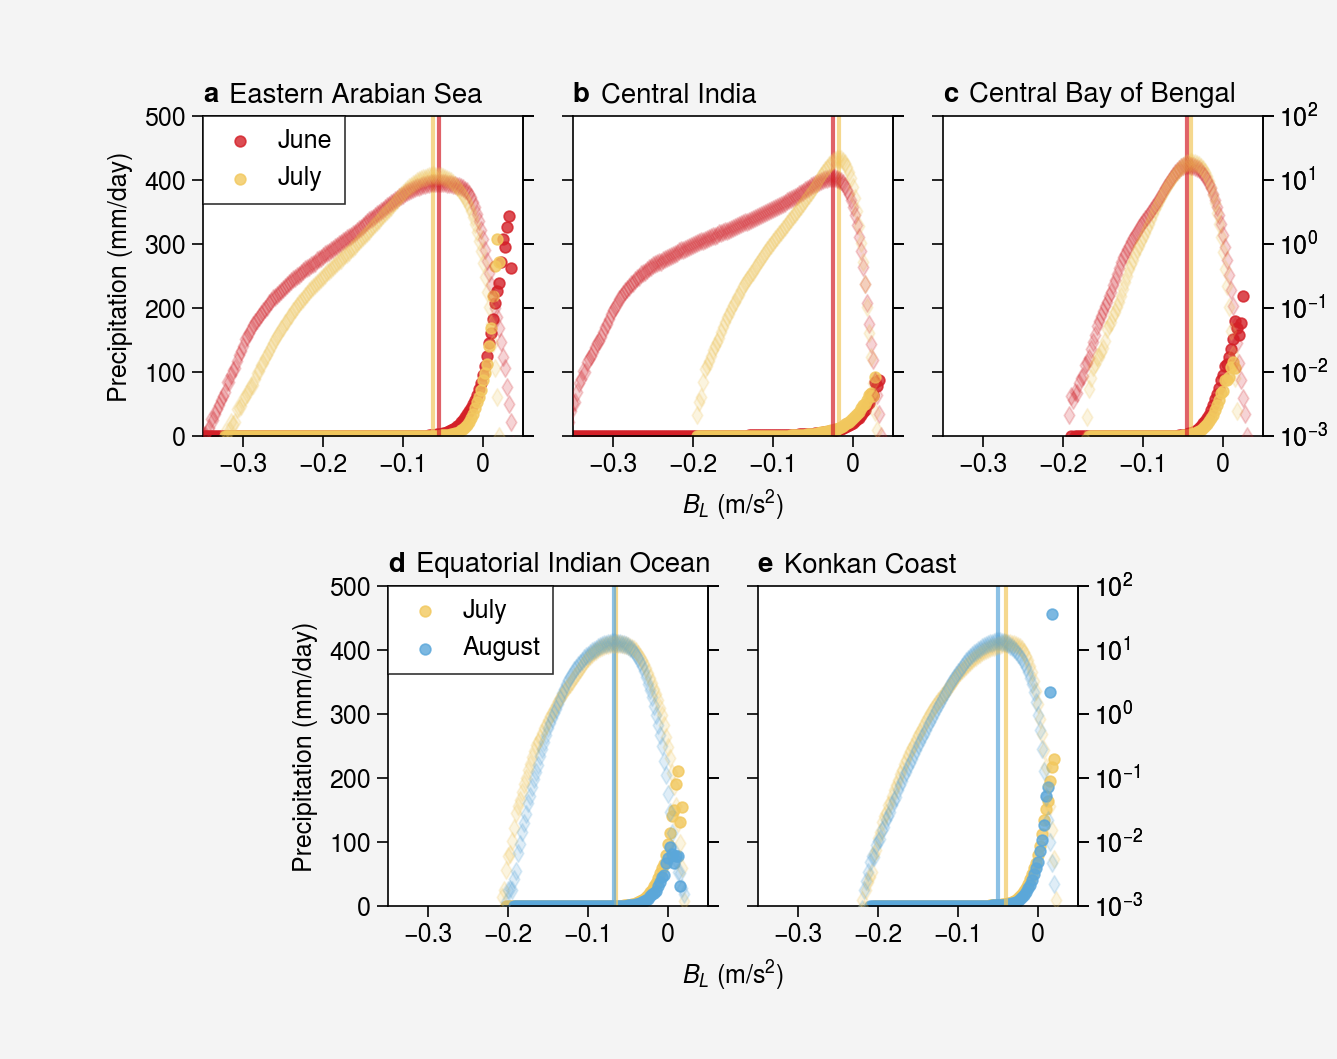

In [7]:
create_plot(hrimergstats,filename='fig_2.jpg')

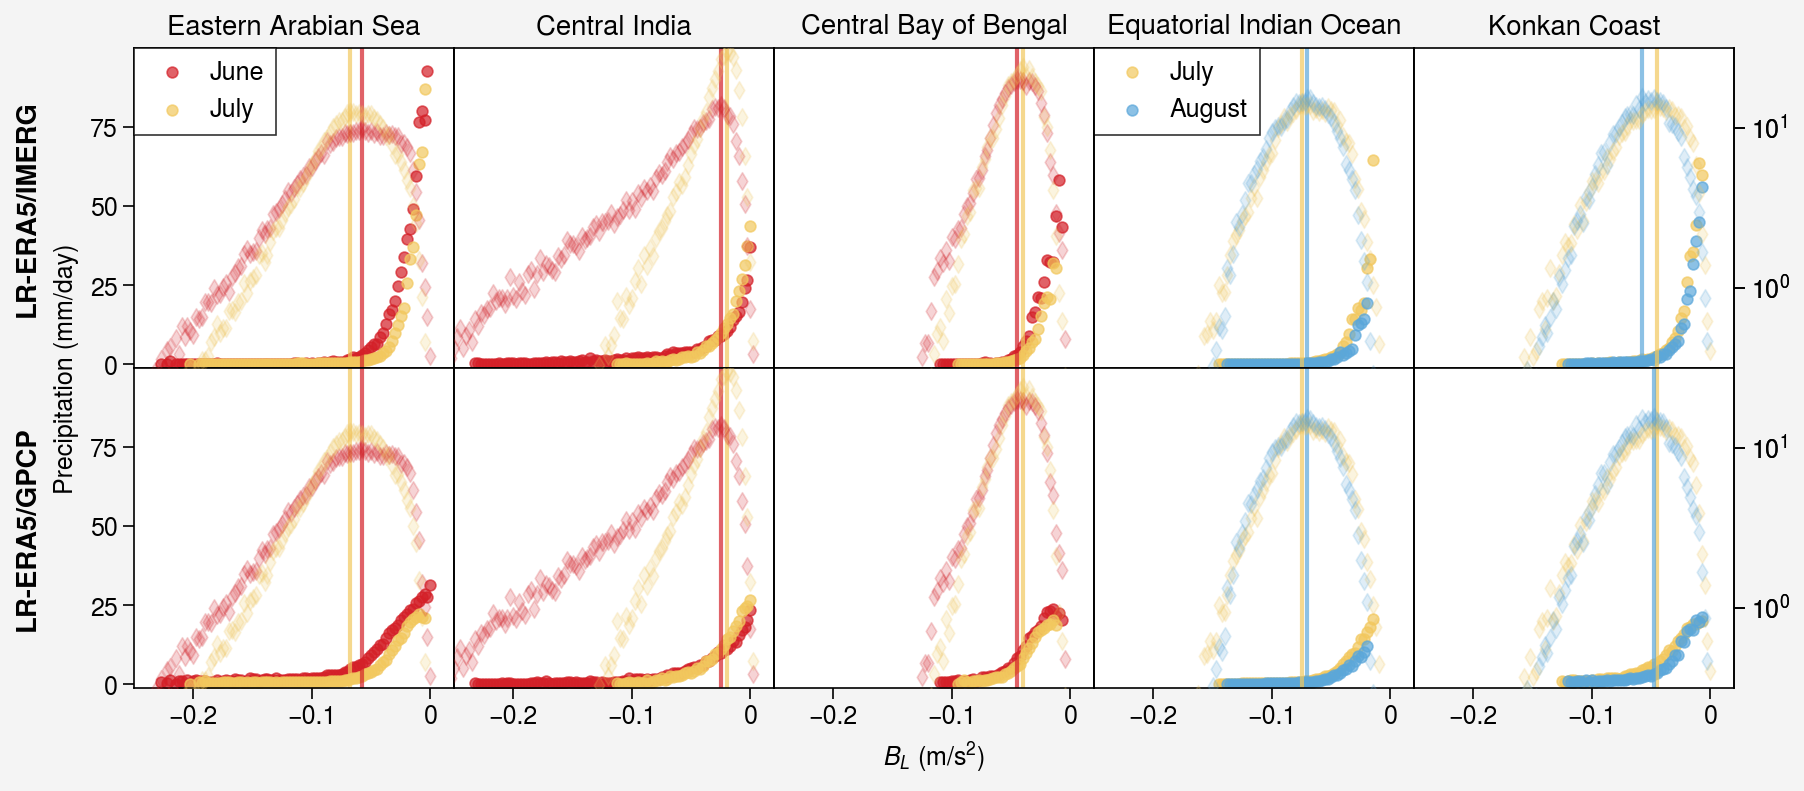

In [8]:
statsdict = [
    (lrimergstats,'LR-ERA5/IMERG'),
    (lrgpcpstats,'LR-ERA5/GPCP')]
create_si_plot(statsdict,filename='fig_S2.jpg')